# Генерация числа

In [1]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.8.0'

# Загрузка и предобработка

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255, x_test / 255
x_train, x_test = x_train[..., None], x_test[..., None]

In [3]:
def one_hot(arr):
    res = np.zeros((arr.shape[0], 10))
    for i, n in enumerate(arr):
        res[i, n] = 1
    return res

y_train_one_hot = one_hot(y_train)
y_test_one_hot = one_hot(y_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot)).shuffle(10_000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot)).batch(32)

num = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
num_onehot = one_hot(num)

# Модель

In [4]:
class GenModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.dense = layers.Dense(784, activation="relu")
        self.reshape = layers.Reshape((28, 28, 1))
        
        self.conv2d5 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop5 = layers.Dropout(0.2)
        
        self.conv2d5 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop5 = layers.Dropout(0.2)
        
        self.conv2d4 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop4 = layers.Dropout(0.2)
        
        self.conv2d3 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop3 = layers.Dropout(0.2)
        
        self.conv2d2 = layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop2 = layers.Dropout(0.2)
        
        self.conv2d1 = layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")
        self.drop1 = layers.Dropout(0.2)
        
        self.conv2dEnd = layers.Conv2D(1, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="tanh")

    def call(self, x):
        
        x = self.dense(x)
        x = self.reshape(x)
        
        x = self.conv2d5(x)
        x = self.drop5(x)
        
        x = self.conv2d4(x)
        x = self.drop4(x)
        
        x = self.conv2d3(x)
        x = self.drop3(x)
        
        x = self.conv2d2(x)
        x = self.drop2(x)
        
        x = self.conv2d1(x)
        x = self.drop1(x)
        
        x = self.conv2dEnd(x)
        
        return x

In [5]:
genModel = GenModel()
lossBinary = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizerAdam = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.BinaryCrossentropy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryCrossentropy(name="test_accuracy")

# Тренировка и Предикт

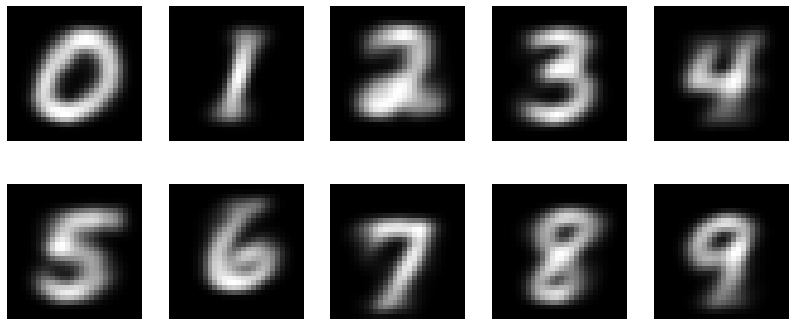

Epoch 1
 Train Loss: 0.23300042748451233 Train Accuracy: 0.2330007404088974

Wall time: 14min 45s


In [6]:
%%time

EPOCHS = 1

for epoch in range(EPOCHS):
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for train_imgs, train_lbls in train_ds:
        
        with tf.GradientTape() as tape:
            pred_imgs = genModel(train_lbls, training=True)
            loss_value = lossBinary(train_imgs, pred_imgs)
            
        grad = tape.gradient(loss_value, genModel.trainable_variables)
        optimizerAdam.apply_gradients(zip(grad, genModel.trainable_variables))
        
        train_loss(loss_value)
        train_accuracy(train_imgs, pred_imgs)

        display.clear_output(wait=True)
        gen_imgs = genModel(num_onehot, training=False).numpy()

        fig, ax = plt.subplots(2, 5, figsize=(14, 6))
        for i, img in enumerate(gen_imgs):
            i, j = i // 5, i % 5
            ax[i, j].imshow(img, cmap="gray")
            ax[i, j].axis("off")
        plt.show()
        
    print(
        f'Epoch {epoch + 1}\n',
        f'Train Loss: {train_loss.result().numpy()}',
        f'Train Accuracy: {train_accuracy.result().numpy()}\n',
    )